In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Download a dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32') / 255, y_train)).shuffle(1024).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test.astype('float32') / 255, y_test)).batch(32)

tf.Tensor(5, shape=(), dtype=uint8)


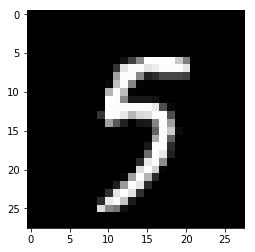

In [0]:
# A quick example of iterating over a dataset object
for image, label in train_ds.take(1):
  plt.imshow(image[0], plt.get_cmap('gray'))
  print(label[0])

In [0]:
class MyLinearModel(Model):
  def __init__(self):
    super(MyLinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(10, activation='softmax', name="dense1")

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

In [0]:
model = MyLinearModel()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# For each epoch
for epoch in range(5):

  # For each batch of images and labels
  for images, labels in train_ds:

    # Open a GradientTape.
    with tf.GradientTape() as tape:

      # Forward pass
      predictions = model(images)

      # Calculate loss
      loss = loss_fn(labels, predictions)

    # Backprop to calculate gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Gradient descent step
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
  print("Epoch {}, Loss: {}".format(epoch, loss))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 0, Loss: 0.4220600724220276
Epoch 1, Loss: 0.09280335903167725
Epoch 2, Loss: 0.20628079771995544
Epoch 3, Loss: 0.06312283128499985
Epoch 4, Loss: 0.3563022017478943


### 2a: Visualize the learned weights

We can interpret a linear model by looking at the weights of the fully connected layer. Modify the below code to create a plot similar to the following:

![Plot of weights](https://storage.googleapis.com/applied-dl/im/a1-3.png)

If you find this section tricky, it is not necessary to complete it to continue with the rest of the assignment.


**TODO**

Modify the below code to retrieve the learned weights. You can use either the public API of a model ```model.get_layer(name)``` then retrieve the weights from that, or (because our model is defined using the Subclassing API), you can access the dense layer directly ```model.d1```.

In [0]:
# There are two ways to retrieve the weights. You can use the public API
# (model.get_layer(name).get_weights()), or you can access the dense layer directly (model.dl) then find the accessor method, or again, access the variable directly.
# Python tip: try ```dir(model.d1)```

# Modify me

weights, bias = model.get_layer(index = 1).get_weights()
# weights, bias = None # get the weights

print(weights)
print("\n**************now let's see the shape of the weights**************\n")
print(weights.shape) 


[[ 0.03211133 -0.04066217  0.02196514 ... -0.02736096  0.00664
   0.02309515]
 [ 0.00361001  0.03319435 -0.07785873 ... -0.01277882 -0.02574356
   0.08188491]
 [-0.04108843 -0.04240116 -0.02108001 ... -0.07863352 -0.04859005
  -0.07363753]
 ...
 [-0.07693467 -0.07114246  0.04548297 ... -0.07467674  0.00960898
   0.0058738 ]
 [ 0.07628215  0.02590251  0.06854589 ... -0.04481921  0.04556464
  -0.00189715]
 [ 0.07691135 -0.02017426 -0.06955741 ...  0.01454324  0.0523219
   0.02812412]]

**************now let's see the shape of the weights**************

(784, 10)


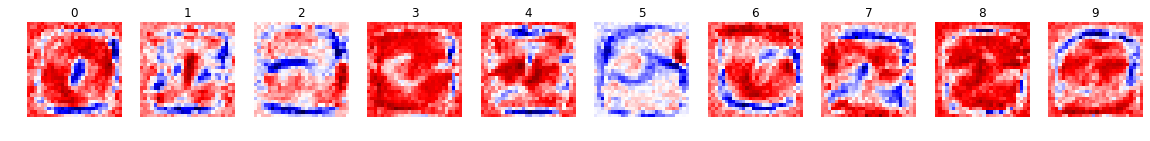

In [0]:
fig, axs = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
  subplot = axs[i]
  subplot.set_title(i)
  subplot.axis('off')
  # Modify me
  weights_t = weights.T
  i_weights = weights_t[i] # Select the weights for the i'th output
  img = i_weights.reshape(28,28)    # Reshape the weights into a 28x28 array
  subplot.imshow(img, plt.get_cmap('seismic'))
plt.show()

### 2b: Implement a deep neural network

**TODO**

Modify this code to create a deep neural network. Train your model using the code below, and compare the accuracy to the linear model above. 

Note: you do not need to modify any sections other than the model definition. 

The code below uses compiled versions of the training and evaluation loops (remove the ```@tf.function``` annotations if you need to debug).

In [0]:
class MyDNN(Model):
  def __init__(self):
    super(MyDNN, self).__init__()

    # Modify me
    self.flatten = Flatten()
    self.d1 = Dense(10, activation='softmax')
    self.d2 = Dense(2, activation ='softmax')

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyDNN()

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [0]:
# These are helper functions we'll use to record loss and accuracy while your model is trained.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
# This method trains the model on a batch of data.

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
# Training and evaluation loop.

EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: nan, Accuracy: 9.870833396911621, Test Loss: nan, Test Accuracy: 9.800000190734863
Epoch 2, Loss: nan, Accuracy: 9.87166690826416, Test Loss: nan, Test Accuracy: 9.800000190734863
Epoch 3, Loss: nan, Accuracy: 9.87166690826416, Test Loss: nan, Test Accuracy: 9.800000190734863
Epoch 4, Loss: nan, Accuracy: 9.87166690826416, Test Loss: nan, Test Accuracy: 9.800000190734863
Epoch 5, Loss: nan, Accuracy: 9.87166690826416, Test Loss: nan, Test Accuracy: 9.800000190734863


### 2c: Provide your own implementation of softmax and use it to train a model

In your linear model above, the starter code looked similar to: 


```
class LinearModel(Model):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)
``` 

Now, create a function:


```
def my_softmax(logits):
  # ...
```

and use it in your model as follows:


```
class LinearModel(Model):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return my_softmax(x)
``` 

Notice, we've removed the built-in activation method on the Dense layer, and added our own to the call method.

Tip: You can implement softmax first using NumPy, if you like, the gradually convert your code to use TensorFlow ops (which begin with tf.\* instead of np.\*).

Notes: 

- Your softmax implementation should be numerically stable. 
- You will need to use tf.* ops in order to use your code to train a model (TF cannot backprop through NumPy operations).

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [0]:
# Download a dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32') / 255, y_train)).shuffle(1024).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test.astype('float32') / 255, y_test)).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# TODO: your code here

def my_softmax(x):  

  softmax = tf.exp(x) / tf.reduce_sum(tf.exp(x))
  return softmax

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return my_softmax(x)
  
model = MyModel()
# TODO
# Add code to train you model, your accuracy should be similar 
# to the linear model.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# These are helper functions we'll use to record loss and accuracy while your model is trained.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

############################################################################################

# This method trains the model on a batch of data.

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
# Training and evaluation loop.

EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.2412148416042328, Accuracy: 93.27166748046875, Test Loss: 0.25848188996315, Test Accuracy: 92.58000183105469
Epoch 2, Loss: 0.23841790854930878, Accuracy: 93.34500122070312, Test Loss: 0.25580644607543945, Test Accuracy: 92.61000061035156
Epoch 3, Loss: 0.23739643394947052, Accuracy: 93.38333892822266, Test Loss: 0.25595206022262573, Test Accuracy: 92.72000122070312
Epoch 4, Loss: 0.23541736602783203, Accuracy: 93.39167022705078, Test Loss: 0.2553325891494751, Test Accuracy: 92.7699966430664
Epoch 5, Loss: 0.23381172120571136, Accuracy: 93.46500396728516, Test Loss: 0.2587677240371704, Test Accuracy: 92.5


### Comparing the accuracy

the linear model:

Epoch 0, Loss: 0.4220600724220276

Epoch 1, Loss: 0.09280335903167725

Epoch 2, Loss: 0.20628079771995544

Epoch 3, Loss: 0.06312283128499985

Epoch 4, Loss: 0.3563022017478943

the neural network :

Epoch 1, Loss: 0.2412148416042328

Epoch 2, Loss: 0.23841790854930878 

Epoch 3, Loss: 0.23739643394947052

Epoch 4, Loss: 0.23541736602783203 

Epoch 5, Loss: 0.23381172120571136

**Above showing that the neural network is more accurate than the linear model when using the same layer and processing the same dataset**